In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.stats import kruskal
from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedShuffleSplit

random.seed(0)
np.random.seed(0)

In [2]:
!dir ashrae-energy-prediction

 Volume in drive C is OS
 Volume Serial Number is 3E0C-6C0C

 Directory of C:\Users\johns\Desktop\probstats2\EnergyPrediction-ASHRAE\code\ashrae-energy-prediction

03/05/2023  05:52 PM    <DIR>          .
03/05/2023  05:52 PM    <DIR>          ..
03/05/2023  05:52 PM            45,527 building_metadata.csv
03/05/2023  05:52 PM       447,562,511 sample_submission.csv
03/05/2023  05:52 PM     1,462,461,085 test.csv
03/05/2023  05:52 PM       678,616,640 train.csv
03/05/2023  05:52 PM        14,787,908 weather_test.csv
03/05/2023  05:52 PM         7,450,075 weather_train.csv
               6 File(s)  2,610,923,746 bytes
               2 Dir(s)  88,509,939,712 bytes free


# Load and Merge Data 
This code assumes that the data folder is located in the same directory as the notebook

In [3]:
building = pd.read_csv("./ashrae-energy-prediction/building_metadata.csv")
train = pd.read_csv("./ashrae-energy-prediction/train.csv")
weather_train = pd.read_csv("./ashrae-energy-prediction/weather_train.csv")

In [4]:
building.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,92111.776398,1967.957037,3.740845
std,5.003432,418.434583,110769.950997,31.054030,3.333683
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


In [5]:
train.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [6]:
weather_train.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.000000,139660.000000,89484.000000,129155.000000,133505.000000,139469.000000
mean,7.478977,14.418106,2.149306,7.350158,0.983047,1016.158038,180.526632,3.560527
std,4.604744,10.626595,2.599150,9.790235,8.463678,7.629684,111.523629,2.335874
min,0.000000,-28.900000,0.000000,-35.000000,-1.000000,968.200000,0.000000,0.000000
25%,3.000000,7.200000,0.000000,0.600000,0.000000,1011.800000,80.000000,2.100000
50%,7.000000,15.000000,2.000000,8.300000,0.000000,1016.400000,190.000000,3.100000
75%,11.000000,22.200000,4.000000,14.400000,0.000000,1020.800000,280.000000,5.000000
max,15.000000,47.200000,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000


In [7]:
df = building.copy()
df = df.merge(train, on='building_id', how='left')
df = df.merge(weather_train, on=['site_id', 'timestamp'], how='left')
del building, train, weather_train

C:\Users\johns\AppData\Local\Temp\ipykernel_20008\1929374606.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


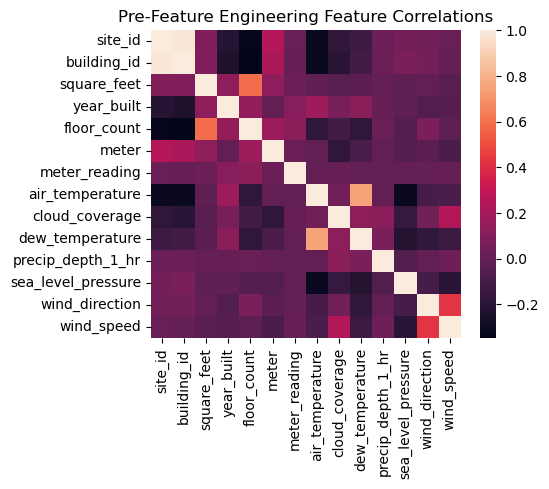

In [8]:
plt.figure(figsize=(5,4))
sns.heatmap(df.corr())
plt.title("Pre-Feature Engineering Feature Correlations")
plt.show()

# Basic Feature Engineering / Manipulation

In [9]:
df['log_square_feet'] = np.log1p(df['square_feet'])
df['log_precip_depth_1_hr'] = np.log1p(df['precip_depth_1_hr'])
df['log_meter_reading'] = np.log1p(df['meter_reading'])


# Fill any infinity values with zero 
df['log_square_feet'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
df['log_precip_depth_1_hr'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# Get time (granular down to the hour, and only one year)
df['timestamp'] = pd.to_datetime(df['timestamp']) 
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.dayofweek

# Track weather metrics means (to detect spikes) 
weather_features = ['cloud_coverage', 'dew_temperature', 'air_temperature', 
                    'sea_level_pressure', 'wind_direction', 'wind_speed', 'precip_depth_1_hr',]

hourly_by_site = df.groupby(['hour', 'month', 'site_id'])[weather_features].mean().reset_index()

df = df.merge(hourly_by_site, on=['hour', 'month', 'site_id'], how='left', suffixes=(None, '_hourly_by_site'))
del hourly_by_site

for feature in weather_features:
    df[feature + "_diff_hourly_from_mean"] = df[feature] - df[feature + "_hourly_by_site"]
    
df = df.drop(columns = [feat + "_hourly_by_site" for feat in weather_features])

# Map meter values to their true name 
# df['meter'] = df['meter'].replace({
#     0: 'electricity',
#     1: 'chilledwater',
#     2: 'steam',
#     3: 'hotwater'
# })

C:\Users\johns\anaconda3\envs\probstats\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,timestamp,meter_reading,air_temperature,...,day,month,weekday,cloud_coverage_diff_hourly_from_mean,dew_temperature_diff_hourly_from_mean,air_temperature_diff_hourly_from_mean,sea_level_pressure_diff_hourly_from_mean,wind_direction_diff_hourly_from_mean,wind_speed_diff_hourly_from_mean,precip_depth_1_hr_diff_hourly_from_mean
0,0,0,Education,7432,2008.0,NaN,0,2016-01-01 00:00:00,0.0,25.0,...,1,1,4,0.321529,10.824694,9.234033,1.845534,-173.654027,-3.546913,NaN
1,0,0,Education,7432,2008.0,NaN,0,2016-01-01 01:00:00,0.0,24.4,...,1,1,4,NaN,11.510807,9.557870,1.977317,-103.606660,-2.291203,-2.061263
2,0,0,Education,7432,2008.0,NaN,0,2016-01-01 02:00:00,0.0,22.8,...,1,1,4,0.398445,11.173830,8.504178,1.497684,-163.955388,-3.440434,-0.095507
3,0,0,Education,7432,2008.0,NaN,0,2016-01-01 03:00:00,0.0,21.1,...,1,1,4,-0.001944,10.519510,7.471662,1.213302,-170.194785,-3.021395,-0.609488
4,0,0,Education,7432,2008.0,NaN,0,2016-01-01 04:00:00,0.0,20.0,...,1,1,4,0.887689,10.316211,6.645303,1.367389,56.531574,-0.631103,-1.319510


Skipping primary_use
Skipping timestamp


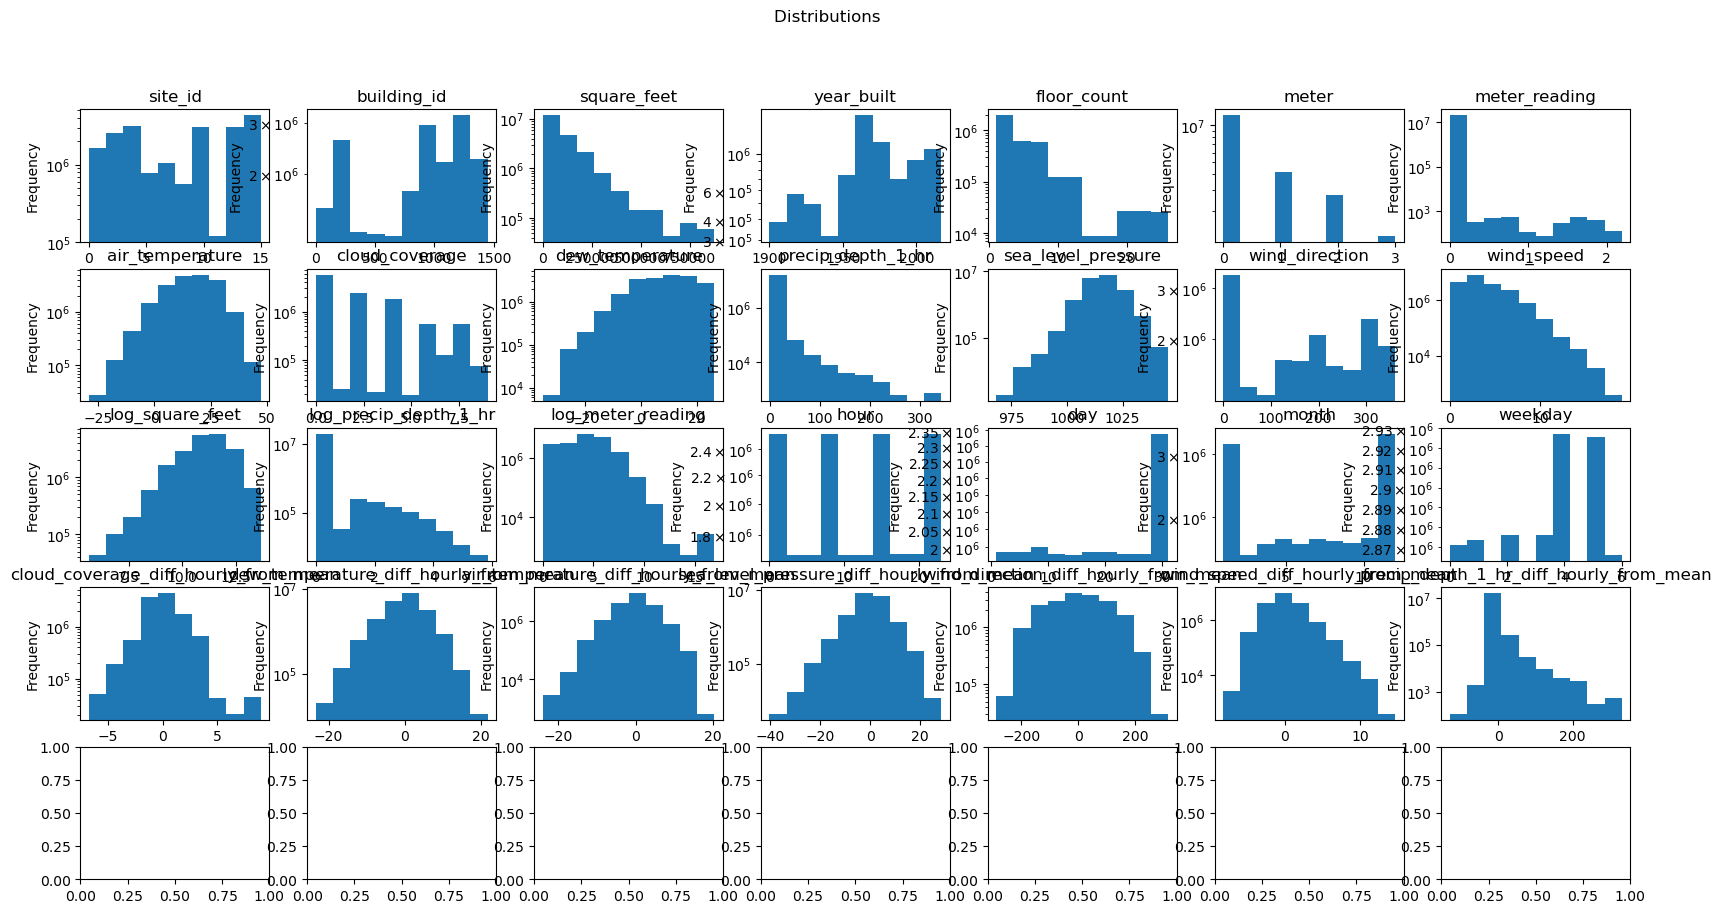

In [11]:
fig, axes = plt.subplots(5, 7, figsize=(20, 10))

# Generate a histogram for each feature 
i = 0
for feat in df.columns:
    try:
        sub_axis = axes[i // 7][i % 7]
        df[feat].plot.hist(ax=sub_axis)
        sub_axis.set_yscale('log')
        sub_axis.set_title(feat)
        
        i += 1 
    except:
        print(f"Skipping {feat}")
       

plt.suptitle("Distributions ")
plt.show()

# Hypothesis Testing 
Given the non-Gaussian nature of the data, I conducted parametric tests to observe the data

In [12]:
# Compare metrics across building IDs 
# for feature in df.columns:
#     _, pval = kruskal(
#         *[df[df['building_id'] == sid][feature].dropna() for sid in df['building_id'].unique()]
#     )
#     print(feature, pval)

In [13]:
# data isn't necessarily linear, observe it with T-SNE
# for meter in df['meter'].unique():
#     data = df[df['meter'] == meter]
#     tsne = TSNE(n_jobs=4)
#     transformed_df = tsne.fit_transform(data)
#     plt.scatter(transformed_df[:,0], transformed_df[:,1], c=data['building_id'], cmap='viridis')
#     plt.title(f"TSNE {meter}")
#     plt.colorbar()
#     plt.show()

# Random Forest
Intuition: climate different per month, should train on 75% of each month's data and then test on 25% of it. This is achieved using a stratified shuffle split, where the month is treated as the class 

In [22]:
splitter = StratifiedShuffleSplit(
    n_splits=4, 
)

n_trees = 50
split = 1 

meter_idx_to_str = {
    0: 'electricity',
    1: 'chilledwater',
    2: 'steam',
    3: 'hotwater'
}


for meter in df['meter'].unique():
    
    print(meter_idx_to_str[meter])
    data = df[df['meter'] == meter]
    
    for train_idx, test_idx in splitter.split(data, data['month']):
        train, test = data.iloc[train_idx], data.iloc[test_idx]

        regressor = RandomForestRegressor(
            n_estimators=n_trees, 
            random_state=0,
            max_depth=5,
            n_jobs=4,
            max_samples=0.1
        )

        regressor.fit(train.drop(columns='meter_reading'), train['meter_reading'])

        y_hat = regressor.predict(test.drop(columns='meter_reading'))

        print(mean_squared_error(test['meter_reading'], y_hat))
        split += 1 

electricity


MemoryError: Unable to allocate 82.8 MiB for an array with shape (10854819,) and data type int64